## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### Then I get the image undistort parameters ,and the undistort result  shown below

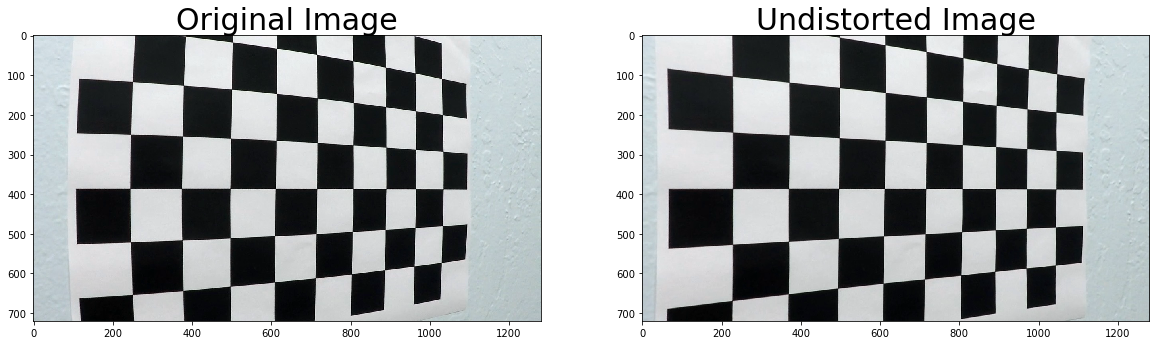

In [2]:
import pickle
%matplotlib inline

img = cv2.imread('../camera_cal/calibration5.jpg')
img = np.array(img)
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/calibration5_und.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### I defined a method to show the images,in order to examine the result of each step . 

In [3]:
def showimage(imagelist,col,row,figsize,IsShowRGB=True):
    fig, axes = plt.subplots(col, row, sharex=True, sharey=True, figsize=figsize)
    for ii, ax in zip(range(col*row), axes.flatten()):
        img = imagelist[ii]
        if(IsShowRGB):
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            ax.imshow(img, aspect='equal')
        ax.imshow(img, aspect='equal',cmap='gray')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
# define a method to show the images

### get the test images list to investigate

In [4]:
import os 
diclist = os.listdir('../test_images/')

imglist =[]
for filename in diclist:
    newname = '../test_images/'+ filename
    img = cv2.imread(newname)
   
    imglist.append(img)

### the original test images were shown as below

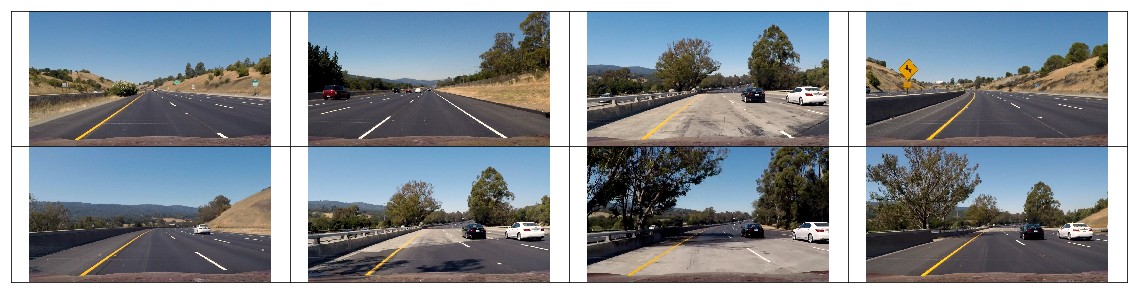

In [5]:
showimage(imglist,2,4,(20,5),True)
# show the raw images

### then I used the  undistort parameters to transform the test images,the results as below

In [6]:
undist_list=[]
for img in imglist:
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    undist_list.append(dst)
# undistorting these images

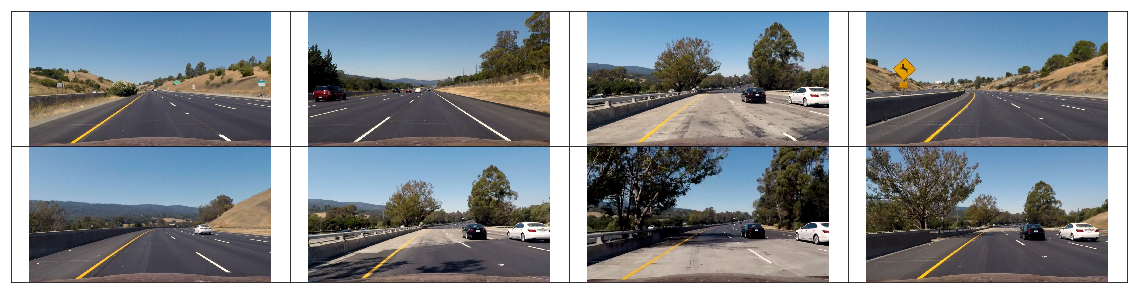

In [7]:
showimage(undist_list,2,4,(20,5),True)
#show these undistorting images

### save the undistorted results

In [8]:
for ind in range(len(undist_list)):
    undname =  diclist[ind].replace('.jpg','_und.jpg')
    undist_img = cv2.cvtColor(undist_list[ind],cv2.COLOR_BGR2RGB)
    plt.imsave('../undist_images/'+undname,undist_img)

### defined a method of extracting the result processed by  gradient magnitude threshold  

In [9]:

def mag_threshold(img, sobel_kernel=3, thresh=(0,255)):
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    return binary_output

### defined a method of extracting the result processed by gradient direction threshold

In [10]:

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output
# Define a function to threshold the value of the gradient direction

### x or y's abs sobel threshold

In [11]:
def abs_sobel_threshold(img,sobel_kernel=3, orient='x', thresh=(0,255)):
    # Convert to grayscale
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel))
  
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
   
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

### HLS color space threshold method 

In [12]:
def HLS_threshold(img,channel='s',thresh=(0,255)):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if(channel=='s'):
        hls_channel = hls[:,:,2]
    if(channel=='h'):
        hls_channel = hls[:,:,0]
    if(channel=='l'):
        hls_channel =hls[:,:,1]
    binary_output = np.zeros_like(hls_channel)
    binary_output[(hls_channel >= thresh[0]) & (hls_channel <= thresh[1])] = 1
    return binary_output


### RGB color space threshold method

In [13]:
def RGB_threshold(img,r=(0,255),g=(0,255),b=(0,255)):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    b_channel = img[:,:,2]
    binary_output = np.zeros_like(img[:,:,0])
    
    binary_output[(r_channel >= r[0]) & (r_channel <= r[1])&
                  (g_channel>=g[0])&(g_channel<=g[1])&(b_channel>=b[0])&(b_channel<=b[1])] = 1
    return binary_output

### after that I defined a combined threshold method to intergrate them

I tried many value scopes and combos in order to get clearer and less noise image.

I add the RGB space threshold to enhance the white and yellow lines performance.

It's the most difficult part that I've tried many many threshold scope and threshold combos,
the principal I think is to extract necessary information in each threshold scope and reduce the noise as much as possible,
because their relationship is 'OR' that means any noise would be added in the final result.


In [14]:
def combined_thresh(img,mag_thresh=(45,100,3),dir_thresh=(0.6,1.25,3),x_thresh=(40,100,3),
                    y_thresh=(40,100,15), hls_thresh = (150,255),l_thresh=(0,70)):

    zshape = img[:,:,0]
    combined_binary = np.zeros_like(zshape)
    
    mag_binary = mag_threshold(img, sobel_kernel=mag_thresh[-1], thresh=mag_thresh[:-1])
    dir_binary =dir_threshold(img, sobel_kernel=dir_thresh[-1], thresh=dir_thresh[:-1])
    x_binary = abs_sobel_threshold(img,sobel_kernel=x_thresh[-1], orient='x', thresh=x_thresh[:-1])
    y_binary = abs_sobel_threshold(img,sobel_kernel=y_thresh[-1], orient='y', thresh=y_thresh[:-1])
    hls_binary = HLS_threshold(img,channel='s',thresh=hls_thresh)
    l_binary = HLS_threshold(img,channel='l',thresh=l_thresh)
    white_binary = RGB_threshold(img,r=(220,255),g=(220,255),b=(220,255))
    yellow_binary =RGB_threshold(img,r=(180,255),g=(180,255),b=(0,100))
    
    combined_binary[((mag_binary == 1) & (dir_binary == 1))|((x_binary == 1)&(y_binary==1)) 
                    | ((hls_binary==1)&(l_binary==0))|(white_binary==1)|(yellow_binary==1)]=1 

    return combined_binary



    

### the results after threshold process like this:

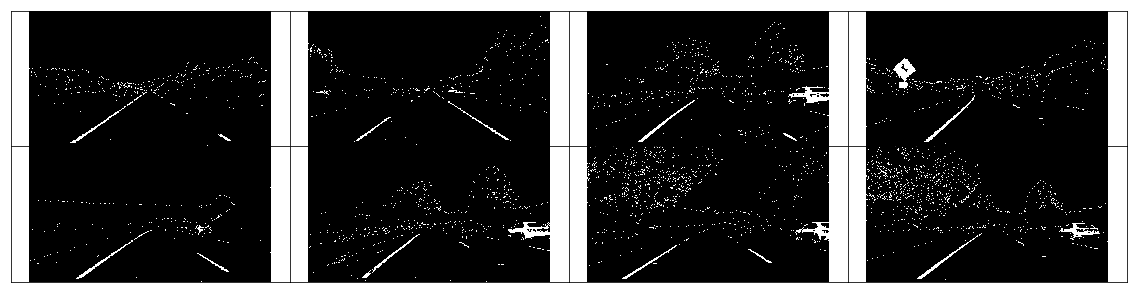

In [15]:
threshed =[]
for i in range(len(undist_list)):
    combined_binary = combined_thresh(undist_list[i])
    newname =  diclist[i].replace('.jpg','_thr.jpg')
    threshed.append(combined_binary)
    plt.imsave('../output_images/'+newname,combined_binary,cmap='gray')
showimage(threshed,2,4,(20,5),False)

### I choose two  straight- lane-images in test images to apply the perspective transform
I pick the mean value of the two straight-lane-images'lines points as the reference points,and set the offset as 300 to make the two lanes in the center of the bird-eye transform image  

I used the 'Painting' software which Windows OS has provided to observe and measure these points in straight lines.The 'Painting' can display the x,y coordinate in pixels.


In [16]:


srcimg = threshed[0]
offset =300

# src =np.float32([[594,448],[685,448],[1086,702],[217,702]])
src1 =np.float32([[579,460],[703,460],[1115,717],[194,717]])
src2 = np.float32([[585,460],[703,460],[1090,718],[234,718]])
src = (src1+src2)/2
#src = src1
#src =np.float32([[617,433],[661,433],[1073,689],[234,689]])
dst =np.float32( [[offset,0],[1280-offset,0],[1280-offset,720],[offset,720]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

### the perspective transformed images like below:

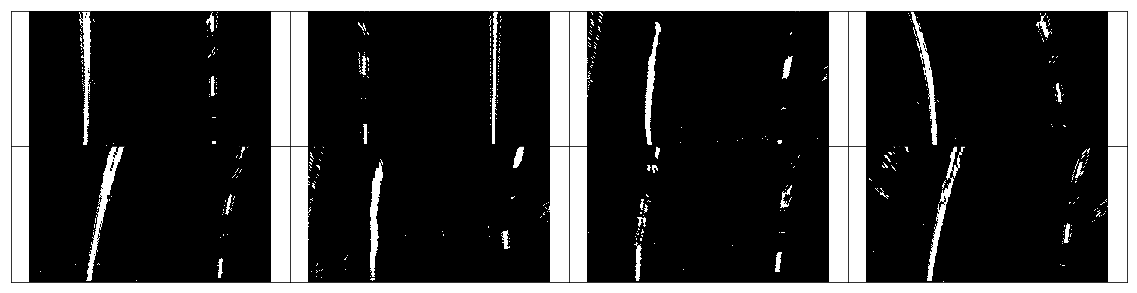

In [17]:
pertrans_img = []
imgsize = (srcimg.shape[0],srcimg.shape[1])
for ind in range(len(threshed)):
    undname =  diclist[ind].replace('.jpg','_und_trans_thr.jpg')
    undist_img =  cv2.warpPerspective(threshed[ind], M, img_size)
    pertrans_img.append(undist_img)
    plt.imsave('../thr_trans/'+undname,undist_img,cmap='gray')
showimage(pertrans_img,2,4,(20,5),False)

### I defined a lane finding  method of sliding window search
compare to the class video I finetuned the parameters and the method will return values like :
* out_img:the image of lane detected and marked by two different color,and if the 'LinesCombined==True',it will add polynomial curve on it 
* left_fitx:the left lane's polynomial x axis points
* right_fitx: the right lane's polynomial x axis points
* right_fit: the  right lane's  polynomial coefficient list
* left_fit:the  left lane's  polynomial coefficient list
* ploty:y axis ponts
* leftdots: the amount of left lane's valid coordinate points
* rightdots:the amount of right lane's valid coordinate points

In [18]:
def windowseach(binary_warped,margin=70,minpix =50,nwindows =9,ShowRectangle = False,LinesCombined =False ):
    
    histogram = np.sum(binary_warped[1*binary_warped.shape[0]//2:,:], axis=0)
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
   
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):

        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if (ShowRectangle==True):
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if(LinesCombined==True):

        l_pts = np.int_([np.dstack((left_fitx,ploty))])
        r_pts = np.int_([np.dstack((right_fitx,ploty))])
        out_img = cv2.cvtColor(out_img,cv2.COLOR_BGR2RGB)
        cv2.polylines(out_img,l_pts,False,(0,255,255),thickness=3,lineType=4)
        cv2.polylines(out_img,r_pts,False,(0,255,255),thickness=3,lineType=4)
    
    leftdots = leftx.shape[0]
    rightdots = rightx.shape[0]
    return out_img,left_fitx,right_fitx,right_fit,left_fit,ploty,leftdots,rightdots
    
# define a function to find the lines by windows searching method. 

### after windowsearch method processed ,the test images like below:

the performance seems not very satisfied,the two lines are apparent not parallel in some images,so I thought it need some  finetunes.

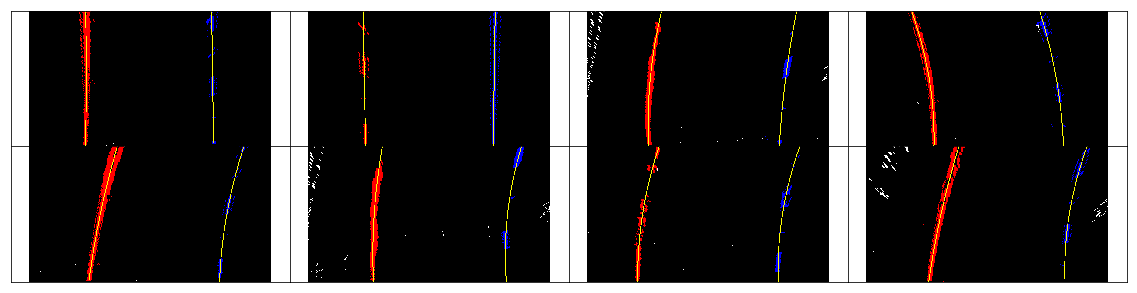

In [44]:
windowlanes = []
for ind in range(len(pertrans_img)):
    window_img,_,_,_,_,_,_,_ =windowseach(pertrans_img[ind],LinesCombined=True)
    windowlanes.append(window_img)
    saveimg =cv2.cvtColor(window_img,cv2.COLOR_BGR2RGB)   
    plt.imsave('../poly/test'+str(ind)+'.jpg',saveimg)
showimage(windowlanes,2,4,(20,5))

### I defined a method to caculate the radius of curvature of the two lanes in an image
* the parameter 'refmeter' indicated the return value was represented by  whether meter or pixels.
* the 'distancex' is the pixels of two lanes distance
* the 'distancey' is the pixels of the dash lane's length

In [20]:
def curverad(ploty,leftx,rightx,distancey = 102,distancex = 720,refmeter = True):

    ym_per_pix =1
    xm_per_pix =1
    if(refmeter==True):
        ym_per_pix = 3/distancey # meters per pixel in y dimension
        xm_per_pix = 3.7/distancex # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
 
    return left_curverad,right_curverad
# if refmeter is False ,the return value is curve rad reference to the pixels.

### I defined a class called 'line'
it used to record the line finding in image,
it has attributes like these :
* fit: the  polynomial coefficient list
* fix,ploy: the polynomial x,y coordinates
* dots: valid pixel points of the original lane which the line is created by,the dots can be used for choose the reference line,a simple way is more dots more accuracy.
* curvrad: the line's radius of curvature represented by meters
* isStraight : to indicate the line whether straight or not.the straight line need to single indicate just because when they are straight,the radius will change in a very large scope , and the radius change rate can not useful as a threshold to jugde how two lines similar.  
* isleft :to indicate the line whether left or not.
* basex: the line x position at the image bottom,use this to caculate the car's position refer to center of lane.
* meanrad: the average of last several times curvrad value .
* meanfit: the average of last servral times fit value,it used to smooth the polynomial
it has a public method :updateline(),used to update the line's information after line's initialization(consider the successive images frame in video scenes).


In [21]:
class line():
    def __init__(self,fit,fitx,ploty,dots,curvrad,isleft = False):
        # the curvrad is the radius of lines
        
        self.fit =fit
        self.fitx =fitx
        self.ploty =ploty
        self.dots =dots 
        self.curvrad = curvrad
        self.isStraight= None
        if((np.absolute(fit[0])<=1e-04)&(np.absolute(fit[1])<=0.05)&(curvrad>1500)):
            self.isStraight =True
        else:
            self.isStraight =False
        self.isleft = isleft
        self.__fit_list = []
        self.__curvradlist = []
        self.meanrad = self.curvrad
        self.meanfit = np.array(fit)
        self.__fit_list.append(fit)
        self.__curvradlist.append(self.curvrad)
        self.basex = fit[0]*720**2+fit[1]*720+fit[2]
        # the basex is the line'x value when y in image botom position.
        
      
        
    def updateline_package(self,fit,fitx,ploty,dots,curvrad,arraylen = 5):
        # I set a  parameter 'arraylen' to record last several frame informations
        self.fit = fit
        self.fitx =fitx
        self.ploty =ploty
        self.dots = dots
        self.curvrad =curvrad
        self.basex = fit[0]*720**2+fit[1]*720+fit[2]
        self.__fit_list.append(fit)
        self.__curvradlist.append(curvrad)
        if len(self.__fit_list)>5:
            self.__fit_list = self.__fit_list[1:]
            self.__curvradlist = self.__curvradlist[1:]
        self.meanrad = np.mean(self.__curvradlist)
        self.meanfit = np.mean(self.__fit_list,axis = 0)
        if((np.absolute(fit[0])<=1e-04)&(np.absolute(fit[1])<=0.05)&(curvrad>1500)):
            self.isStraight =True
        else:
            self.isStraight =False
        
        
    def updateline(self,templine,arraylen = 5):
        # I set a  parameter 'arraylen' to record last several frame informations
        self.fit = templine.fit
        self.fitx =templine.fitx
        self.ploty =templine.ploty
        self.dots = templine.dots
        self.curvrad =templine.curvrad
        self.basex = templine.fit[0]*720**2+templine.fit[1]*720+templine.fit[2]
        self.__fit_list.append(templine.fit)
        self.__curvradlist.append(templine.curvrad)
        if len(self.__fit_list)>5:
            self.__fit_list = self.__fit_list[1:]
            self.__curvradlist = self.__curvradlist[1:]
        self.meanrad = np.mean(self.__curvradlist)
        self.meanfit = np.mean(self.__fit_list,axis = 0)
        self.isStraight = templine.isStraight
    

### I have mentioned the lines which found in window sliding search were need to finetune, so I defined a method to ajust them.
* the method need two parameters , leftline and rightline, two instances of class 'line' left line and right line.

the principal is : 
* pick the line which has more lane pixels points as the reference line(more points mean more accuracy in polynomial fit) .
* if the lines close to a straight line,ajust them to straight lines in window sliding search mode,if in continuous frame mode no operate (consider the car pass large scale corner would have some delay to make two lines straight ).
* if the lines not straight, and the lines's radius difference rate in no-finetune threshold scope, no need to ajust.
* if the lines not straight, and the lines's radius difference rate out of no-finetune threshold scope, ajust non-reference-line based the two lines' mean poly-fit-value.
* in window sliding search mode, if the ajusted-lines's radius difference rate still out of max-threshold scope(it would imply some lines not correct identified in detected step),use the reference line polynomial coefficient value(except constant value) to instead of the other line's.In continuous frame mode,it maybe imply this frame is a bad frame,it would be dropped.

In [23]:
def ajustlines(leftline,rightline,isWindowMode = True):
    
    if(leftline.dots>=rightline.dots):
        refline = leftline
        ajustline = rightline
    else :
        refline =rightline
        ajustline =leftline
        # pick the more points one as the reference line. 
    if refline.isStraight == True:
        if isWindowMode == True:
            if ajustline.isStraight == False:
                ajustline.fit[0] = refline.fit[0]
                ajustline.fit[1] = refline.fit[1]
                ajust_fit2 = ajustline.fit[0]*360**2+ajustline.fit[1]*360+ajustline.fit[2]
                ajustline.fit[2] = ajust_fit2
                ajustline.fitx = ajustline.fit[0]*ajustline.ploty**2+ajustline.fit[1]*ajustline.ploty+ajustline.fit[2]
                ajustline.isStraight = True
        else :
            pass
    
    else:
        radmargin = 100*np.absolute(refline.curvrad-ajustline.curvrad)/max(refline.curvrad,ajustline.curvrad)
        
        if(radmargin>15):
            # set the no-finetune threshold 
            # out of this scope will trigger the ajust algorithm 
            ajust_midpoint =  ajustline.fit[0]*360**2+ajustline.fit[1]*360+ajustline.fit[2]
            ajust_fit2 =ajust_midpoint-((ajustline.fit[0]+refline.fit[0])*360**2/2+(ajustline.fit[1]+refline.fit[1])*360/2)
            ajust_fit0 = (ajustline.fit[0]+refline.fit[0])/2
            ajust_fit1 =(ajustline.fit[1]+refline.fit[1])/2
            ajustline.fit[0] = ajust_fit0
            ajustline.fit[1] = ajust_fit1
            ajustline.fit[2] = ajust_fit2
            ajustline.fitx = ajustline.fit[0]*ajustline.ploty**2+ajustline.fit[1]*ajustline.ploty+ajustline.fit[2]
            ref720 = refline.fit[0]*720**2+refline.fit[1]*720+refline.fit[2]
            ajust720 =  ajustline.fit[0]*720**2+ajustline.fit[1]*720+ajustline.fit[2]
            distance = np.absolute(ref720-ajust720)
            _,ajustcrad = curverad(refline.ploty,refline.fitx,ajustline.fitx,distancex = distance)
            uradmargin = 100*np.absolute(refline.curvrad-ajustcrad)/max(refline.curvrad,ajustcrad)
            ajustline.curvrad = ajustcrad
            ajustline.isStraight = False
            if(isWindowMode==True):
                if(uradmargin>=35):
                    # set a max-threshold, this value means : after ajusted ,2 lines still have a large margin in radius
                    # the phenomenon  implies maybe  the lines  have some problems in lines identify step,so that the lanes in images
                    # lack of information to poly-fit reasonable lines.
                    # in that case,I choose the more points lines as reference,
                    # and the other one use the reference line's fit coefficient instead(except constant term).
                    ajustline.fit[0] = refline.fit[0]
                    ajustline.fit[1] = refline.fit[1]
                    ajustline.fit[2] = ajust_midpoint-(refline.fit[0]*360**2+refline.fit[1]*360)
                    ajustline.fitx = ajustline.fit[0]*ajustline.ploty**2+ajustline.fit[1]*ajustline.ploty+ajustline.fit[2]
                    ajustline.curvrad = refline.curvrad
                    ajustline.isStraight = refline.isStraight 
            
        
    return refline,ajustline

### the ajustlines method was tested,and the results shown below:
the results look more parallel and reasonable compared to ajusted before .

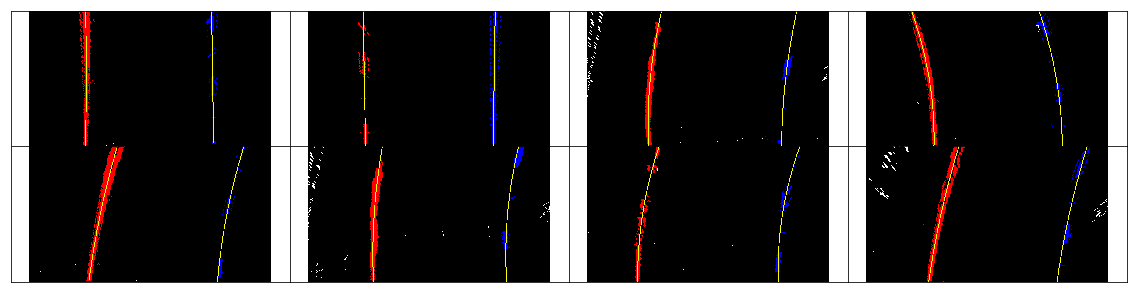

In [54]:
ajustimg =[]
for ind in range(len(pertrans_img)):
    binary_image = pertrans_img[ind]
    out_img,left_fitx,right_fitx,right_fit,left_fit,ploty,leftdots,rightdots = windowseach(binary_image,ShowRectangle = False,
                                                                                           LinesCombined = False)
    out_img =cv2.cvtColor(out_img,cv2.COLOR_BGR2RGB)   
    r720 =  right_fit[0]*720**2+right_fit[1]*720+right_fit[2]
    l720 =  left_fit[0]*720**2+left_fit[1]*720+left_fit[2]
    distance = np.absolute(r720-l720)
    lcrad,rcrad = curverad(ploty,left_fitx,right_fitx,distancex = distance)
    leftline = line(left_fit,left_fitx,ploty,leftdots,lcrad)
    rightline = line(right_fit,right_fitx,ploty,rightdots,rcrad)
    refline,ajustline = ajustlines(leftline,rightline)
    l_pts = np.int_([np.dstack((refline.fitx,refline.ploty))])
    r_pts = np.int_([np.dstack((ajustline.fitx,ajustline.ploty))])
    cv2.polylines(out_img,l_pts,False,(0,255,255),thickness=3,lineType=4)
    cv2.polylines(out_img,r_pts,False,(0,255,255),thickness=3,lineType=4)
    
    #saveimg =cv2.cvtColor(out_img,cv2.COLOR_BGR2RGB)   
    saveimg = out_img
    #plt.imsave('../poly/ajust'+str(ind)+'.jpg',saveimg)
    ajustimg.append(out_img)
    
showimage(ajustimg,2,4,(20,5))

### define a method for caculating and printing the car's position to center of lane.

In [28]:

def car_position (lline,rline):
    distance =np.absolute(lline.basex-rline.basex)
    meter_perpixel =3.7/distance
    lanemid = np.mean([lline.basex,rline.basex])
    position = (640 - lanemid)*meter_perpixel
    display = None
    position = round(position,3)
    if(position>0):
        display = 'Vehicle is '+str(np.absolute(position))+'m right of the center'
    else:
        display = 'Vehicle is '+str(np.absolute(position))+'m left of the center'
    return display

### define a method for printing the radius information

In [29]:
def print_radius(lline,rline):
    rad = np.mean([lline.meanrad,rline.meanrad])
    rad = round(rad,0)
    display = 'Radius of Curvature = '+str(rad)+' m' 
    return display

### defined a method to draw the plane surrounded by the lines

the parameter 'smooth' used in the video scenes,in 'smooth' modethe method will read the mean polyfit value of lines

if IsPutText == True, it will generate the car's position and radius information

In [35]:
def drawlines(undist,leftline,rightline,smooth=False,IsBGR=True,IsPutText=False):
    warp_zero = np.zeros_like(undist[:,:,0]).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    if(smooth==True):
        lfitx =leftline.meanfit[0]*leftline.ploty**2 + leftline.meanfit[1]*leftline.ploty + leftline.meanfit[2] 
        rfitx =rightline.meanfit[0]*rightline.ploty**2 + rightline.meanfit[1]*rightline.ploty + rightline.meanfit[2] 
        pts_left = np.array([np.transpose(np.vstack([lfitx, leftline.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([rfitx, rightline.ploty])))])
    else:
        pts_left = np.array([np.transpose(np.vstack([leftline.fitx, leftline.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([rightline.fitx, rightline.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (warp_zero.shape[1], warp_zero.shape[0])) 
    # Combine the result with the original image
    
    if(IsPutText==True):
        position_info = car_position(leftline,rightline)
        radinfo = print_radius(leftline,rightline)
        undist = cv2.putText(undist,radinfo,(260,100),fontFace =cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1.5,color =[255,255,255],thickness=3)
        undist = cv2.putText(undist,position_info,(200,150),fontFace =cv2.FONT_HERSHEY_SIMPLEX, fontScale = 1.5,color =[255,255,255],thickness=3)
    if(IsBGR==True):
        undist=  cv2.cvtColor(undist,cv2.COLOR_BGR2RGB)   
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

### defined a method to successive  search , it based the result of last time lines search

this part's source code was from the course tips,and I copied them here.

In [36]:
def autosearch(binary_warped,left_fit,right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    leftdots = leftx.shape[0]
    rightdots = rightx.shape[0]
    return out_img,left_fit,left_fitx,right_fit,right_fitx,ploty,leftdots,rightdots

### defined a class 'imgprocess' to intergrate each step method

the private method __comparelines() used to  decide whether the lines detected in line search step were valid lines,it applied after successive search step(in video detect scene),it compare difference of the radius of two lanes' line and the radius of two same side lines in consecutive frames.if the line is a valid line,it will be updated to the current instance,else it will be dropped.



the pipeline() method is used to apply a process pipeline of the video clipped to images.  
the private attribute __failcounter to count the number of dropped lines in consecutive frames in  successive search step.if the __failcounter out of the threshold value,it will restart the window slide search process.
when finished lines search step(window sliding search or successive frame search),it would apply lines ajust process.

the pipeline_image() method is used to apply a process pipeline for the test image. consider these images are not from consecutive video frames,the method only use window slide search to detect the lines. 


In [37]:
class imgprocess():
    def __init__(self):
        self.img = None
        self.undist_img = None
        self.undrgb_img =None
        self.thresh_img = None
        self.birdeye_img =None
        
        self.rightline = None
        self.leftline = None
        self.__failcounter = 0
        self.__recover = True
        self.result =None
        self.restartcounter = 0
        self.testcounter = 0
    def undistort_img(self,img):
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        self.img = img
        self.undist_img = dst
        self.undrgb_img = cv2.cvtColor(dst,cv2.COLOR_BGR2RGB)
    def combined_thresh(self):
        self.thresh_img=combined_thresh(self.undist_img)
        
    def img_transform(self):
        self.birdeye_img =  cv2.warpPerspective(self.thresh_img, M, (self.img.shape[1],self.img.shape[0]))
    def windowseach(self):
        _,left_fitx,right_fitx,right_fit,left_fit,ploty,leftdots,rightdots = windowseach(self.birdeye_img)
        r720 =  right_fit[0]*720**2+right_fit[1]*720+right_fit[2]
        l720 =  left_fit[0]*720**2+left_fit[1]*720+left_fit[2]
        distance = np.absolute(r720-l720)
        lcrad,rcrad = curverad(ploty,left_fitx,right_fitx,distancex = distance)
        self.leftline = line(left_fit,left_fitx,ploty,leftdots,lcrad,True)
        self.rightline = line(right_fit,right_fitx,ploty,rightdots,rcrad)
        self.__recover=False
        self.__failcounter = 0
        self.restartcounter+=1
    def ajustlines(self):
        refline,ajustline= ajustlines(self.leftline,self.rightline)
        if(refline.isleft==True):
            self.leftline = refline
            self.rightline = ajustline
        else:
            self.leftline = ajustline
            self.rightline = refline
    def autosearch(self):
        _,left_fit,left_fitx,right_fit,right_fitx,ploty,leftdots,rightdots= autosearch(self.birdeye_img,
                                                                                       self.leftline.fit,self.rightline.fit)
        r720 =  right_fit[0]*720**2+right_fit[1]*720+right_fit[2]
        l720 =  left_fit[0]*720**2+left_fit[1]*720+left_fit[2]
        distance = np.absolute(r720-l720)
        lcrad,rcrad = curverad(ploty,left_fitx,right_fitx,distancex = distance)
        
        temp_leftline = line(left_fit,left_fitx,ploty,leftdots,lcrad,True)
        temp_rightline = line(right_fit,right_fitx,ploty,rightdots,rcrad)
    
        refline,ajustline = ajustlines(temp_leftline,temp_rightline,False)
        self.testcounter = self.testcounter 
        
        if(refline.isleft==True):
            temp_leftline = refline
            temp_rightline = ajustline
        else:
            temp_leftline = ajustline
            temp_rightline = refline
        self.__comparelines(temp_leftline,temp_rightline)
       
     
    def __comparelines(self,temp_lline,temp_rline):
        # I think the main purpose to compare the lines found in continuous frame search mode is that:
        # 1.avoiding wrong lines caused by bad frame
        # 2.avoiding inaccurate lines caused by searching algorithm defect.
        
        lastmeanrad= np.mean([self.leftline.curvrad,self.rightline.curvrad])
        # lastmeanrad is the last frame mean radius of two lines
        maxrad = max(temp_lline.curvrad,temp_rline.curvrad)
        temp_meanrad = np.mean([temp_lline.curvrad,temp_rline.curvrad])
        temp_linemargin = 100*(temp_lline.curvrad -temp_rline.curvrad)
        linesmargin_rate = temp_linemargin/maxrad
        # linesmargin_rate measure the two temp lines(find in current image) radius margin
        cons_rate = np.absolute(temp_meanrad-lastmeanrad)/lastmeanrad
        # cons_rate measure the consecutive two frame 's radius margin.
        if(self.leftline.dots>self.rightline.dots):
            refline = self.leftline
        else:
            refline = self.rightline
        # identify the reference line.the method is simple but more or less has some defect.
        
        
        if(refline.isStraight ==False):
            # if the reference line is not a straight line and one of the current line are straight line
            # we should consider it as a valid line. because the straight line's check is  relatively strick
        
            if((temp_lline.isStraight == True)|(temp_rline.isStraight == True)):
                self.leftline.updateline(temp_lline)
                self.rightline.updateline(temp_rline)
                self.__failcounter = 0
            else:
            # else all of this frame are curve lines ,we need to examine margins between the  lines,
            # I used two conditions : 
            # 1.the linesmargin_rate : to check the right line and left line in same frame whether similar or not
            # 2.the cons_rate :to check the 2 continuous frames lines whether similar or not
            # because of the right line and left line in same frame have been ajust in last step,in most situation 
            # the margin between the two lines would lower. Similarly,there are dozens of frames in one second,the 
            # two continuous frames would have tiny different in most cases.
            
                if((linesmargin_rate<40)&(cons_rate<35)):
                    self.leftline.updateline(temp_lline)
                    self.rightline.updateline(temp_rline)
                    self.__failcounter = 0
                else:
                    self.__failcounter+=1
        else:
            # last frame lines are straight lines,if this frame near or just be stright lines ,we record them.
            if(((temp_lline.curvrad>1500)&(temp_rline.curvrad>1500))|((temp_lline.isStraight==True)|temp_lline.isStraight==True)):
                self.leftline.updateline(temp_lline)
                self.rightline.updateline(temp_rline)
                self.__failcounter = 0
            else:
            # else,drop this frame lines
                self.__failcounter+=1
                
                
        
    def drawlines(self,smooth=True,IsBGR=False,IsPutText=True):
        self.result = drawlines(self.undist_img,self.leftline,self.rightline,smooth,IsBGR,IsPutText)
    
    
    def pipeline(self,img):
        self.undistort_img(img)
        self.combined_thresh()
        self.img_transform()
        if(self.__recover==True):
            self.windowseach()
            self.ajustlines()
        else:
            if(self.__failcounter<5):
                self.autosearch()
            else:
                self.windowseach()
                self.ajustlines()
        self.drawlines()
        return self.result
    def pipeline_image(self,img):
        self.undistort_img(img)
        self.combined_thresh()
        self.img_transform()
        self.windowseach()
        self.ajustlines()
        self.drawlines(smooth=False,IsBGR=True,IsPutText=True)
        return self.result
        
        

### use the class 'imgprocess',after pipeline process ,the images shown in below:

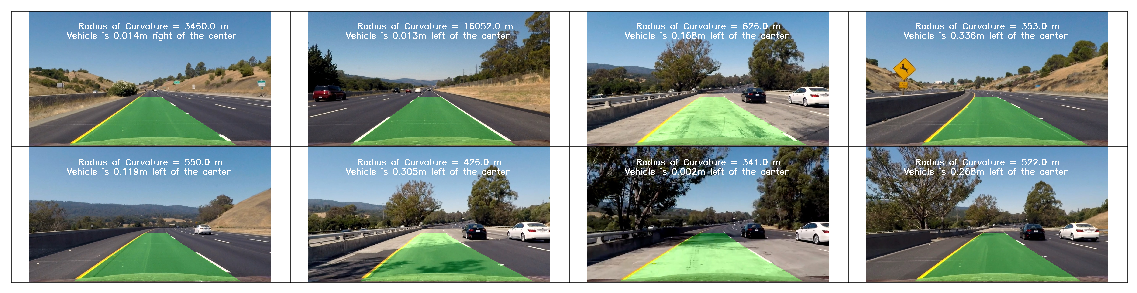

In [39]:
testimg_proc= imgprocess()

finalresult = []
for ind in range(len(imglist)):
    testimg =  testimg_proc.pipeline_image(imglist[ind])
    finalresult.append(testimg)
    plt.imsave('../output_images_final/test'+str(ind)+'.jpg',testimg)
showimage(finalresult,2,4,(20,5),False)

In [40]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
white_output = '../test_videos_output/project_video.mp4'
video_linesdetect =imgprocess()
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(video_linesdetect.pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../test_videos_output/project_video.mp4
[MoviePy] Writing video ../test_videos_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:20<00:00,  4.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../test_videos_output/project_video.mp4 

Wall time: 5min 21s


In [42]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))